# **Import the Libraries**

In [ ]:
# Document Collection, Tokenizer, Normalization Pipeline on IMDB dataset
import os
import tarfile
import random
import pandas as pd
import numpy as np
import nltk
import logging
import time
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
nltk.download('punkt')
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rohit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rohit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rohit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **STEP 1: DATA LOADING AND PREPROCESSING**

## Load the Dataset from Tensorflow Datasets

In [3]:
# --- Use TensorFlow Datasets to load IMDB ---
import tensorflow as tf
import tensorflow_datasets as tfds

# Load IMDB reviews dataset from TensorFlow Datasets
# as_supervised=True gives (text, label) pairs
(ds_train, ds_test), ds_info = tfds.load(
    "imdb_reviews",
    split=["train", "test"],
    as_supervised=True,
    with_info=True
)

# --- Step 2: Collect 1000 positive + 1000 negative from the training split ---

documents = []
pos_count = 0
neg_count = 0
TARGET_PER_CLASS = 1000

# Convert TFDS dataset to NumPy for easy iteration
for text, label in tfds.as_numpy(ds_train.shuffle(25000, seed=42)):
    text_str = text.decode("utf-8")
    label_int = int(label)

    if label_int == 1 and pos_count < TARGET_PER_CLASS:
        documents.append((text_str, "positive"))
        pos_count += 1
    elif label_int == 0 and neg_count < TARGET_PER_CLASS:
        documents.append((text_str, "negative"))
        neg_count += 1

    if pos_count >= TARGET_PER_CLASS and neg_count >= TARGET_PER_CLASS:
        break

print(f"Collected {pos_count} positive and {neg_count} negative reviews.")

# Shuffle the dataset
random.shuffle(documents)

# Convert to pandas DataFrame
df = pd.DataFrame(documents, columns=["text", "label"])
df.head()

2025-12-07 23:01:17,973 : INFO : No config specified, defaulting to config: imdb_reviews/plain_text
2025-12-07 23:01:17,981 : INFO : Load dataset info from C:\Users\Rohit\tensorflow_datasets\imdb_reviews\plain_text\1.0.0
2025-12-07 23:01:17,989 : INFO : Creating a tf.data.Dataset reading 1 files located in folders: C:\Users\Rohit\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.
2025-12-07 23:01:18,128 : INFO : Creating a tf.data.Dataset reading 1 files located in folders: C:\Users\Rohit\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.
2025-12-07 23:01:18,157 : INFO : Constructing tf.data.Dataset imdb_reviews for split ['train', 'test'], from C:\Users\Rohit\tensorflow_datasets\imdb_reviews\plain_text\1.0.0


Collected 1000 positive and 1000 negative reviews.


,text,label
0,"I like my Ronald Colman dashing and debonair, ...",positive
1,I first saw this movie on television some year...,positive
2,"Have you ever, or do you have, a pet who's bee...",positive
3,this was a fabulous adaptation of Jane Eyre. t...,positive
4,This is a truly magnificent and heartwrenching...,positive


## Data Distribution Exploration

In [4]:
print("Dataset shape:", df.shape)
print("\nLabel distribution:")
print(df['label'].value_counts())

df[['text', 'label']].head()


Dataset shape: (2000, 2)

Label distribution:
label
positive    1000
negative    1000
Name: count, dtype: int64


,text,label
0,"I like my Ronald Colman dashing and debonair, ...",positive
1,I first saw this movie on television some year...,positive
2,"Have you ever, or do you have, a pet who's bee...",positive
3,this was a fabulous adaptation of Jane Eyre. t...,positive
4,This is a truly magnificent and heartwrenching...,positive


## Tokenization

In [5]:
first_review = df.loc[0, "text"]
first_review_tokens = word_tokenize(first_review)

print("=== FIRST REVIEW (text sample) ===")
print(first_review[:300], "...")

print("\n=== TOKENIZED OUTPUT ===")
print(first_review_tokens[:30])


=== FIRST REVIEW (text sample) ===
I like my Ronald Colman dashing and debonair, the fellow you see in such films as If I Were King and Kismet. I like him as the epitome of civilization as in The Lost Horrizon and Random Harvest. A brooding Colman isn't a favorite of mine.<br /><br />But in A Double Life precisely because his part as ...

=== TOKENIZED OUTPUT ===
['I', 'like', 'my', 'Ronald', 'Colman', 'dashing', 'and', 'debonair', ',', 'the', 'fellow', 'you', 'see', 'in', 'such', 'films', 'as', 'If', 'I', 'Were', 'King', 'and', 'Kismet', '.', 'I', 'like', 'him', 'as', 'the', 'epitome']


## Normalization and Stopwords removal

In [6]:
def normalize_and_remove_stops(tokens):
    """
    1. Converts all tokens to lowercase (Normalization).
    2. Removes common English stop words.
    """
    # 1. Normalization: Convert to lowercase
    normalized_tokens = [token.lower() for token in tokens]

    # 2. Stop Words Removal
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in normalized_tokens if token not in stop_words]
    
    return filtered_tokens

# Process our IMDB review tokens
cleaned_tokens = normalize_and_remove_stops(first_review_tokens)

print("--- NORMALIZATION & STOP WORDS REMOVAL ---")
print(cleaned_tokens[:30])


--- NORMALIZATION & STOP WORDS REMOVAL ---
['like', 'ronald', 'colman', 'dashing', 'debonair', ',', 'fellow', 'see', 'films', 'king', 'kismet', '.', 'like', 'epitome', 'civilization', 'lost', 'horrizon', 'random', 'harvest', '.', 'brooding', 'colman', "n't", 'favorite', 'mine.', '<', 'br', '/', '>', '<']


## Train-Test Split the Dataset

In [7]:
X = df["text"].values          # Raw review text
y = df["label"].values         # "Positive" / "Negative"

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Train size:", len(X_train))
print("Test size :", len(X_test))

Train size: 1500
Test size : 500


# **STEP 2: TF-IDF FEATURE EXTRACTION ON IMDB REVIEWS**

## TF-IDF Vectorization

In [8]:
"""
TF-IDF (Term Frequency–Inverse Document Frequency) does:
- Term Frequency (TF): how often a word appears in a document.
- Inverse Document Frequency (IDF): down-weights words that appear in many documents.
Result: words that are frequent in a document but rare across the corpus get higher weights.
"""
vectorizer = TfidfVectorizer(
    max_features=5000,      # limit vocabulary size for practicality
    ngram_range=(1, 1),     # unigrams only for now
    lowercase=True,         # convert to lowercase
    stop_words='english'    # remove English stopwords
)

# Fit on training data only (to avoid data leakage)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

print("\n=== TF-IDF MATRIX INFO ===")
print("Train TF-IDF shape:", X_train_tfidf.shape)
print("Test TF-IDF shape :", X_test_tfidf.shape)


=== TF-IDF MATRIX INFO ===
Train TF-IDF shape: (1500, 5000)
Test TF-IDF shape : (500, 5000)


## Vocabulary Inspection

In [9]:
vocab = vectorizer.get_feature_names_out()
print("\nVocabulary size:", len(vocab))

print("\nSample of first 100 features:")
print(vocab[:100])


Vocabulary size: 5000

Sample of first 100 features:
['00' '000' '10' '100' '11' '12' '13' '14' '15' '16' '17' '18' '1930'
 '1930s' '1932' '1935' '1936' '1939' '1940' '1943' '1945' '1950' '1950s'
 '1960' '1970s' '1973' '1978' '1979' '1980' '1980s' '1983' '1985' '1990'
 '1990s' '1996' '1997' '1999' '1st' '20' '2000' '2001' '2002' '2003'
 '2004' '2005' '2006' '2008' '20th' '22' '25' '26' '30' '30s' '35' '40'
 '400' '50' '50s' '60' '60s' '70' '70s' '73' '80' '80s' '90' '90s' '99'
 '999' 'abandoned' 'ability' 'able' 'abraham' 'abruptly' 'absence'
 'absent' 'absolute' 'absolutely' 'absorbed' 'absurd' 'abuse' 'abused'
 'academy' 'accent' 'accents' 'accept' 'acceptable' 'accepted' 'accepting'
 'accepts' 'access' 'accident' 'accidentally' 'accompanied' 'accomplished'
 'according' 'account' 'accuracy' 'accurate' 'accurately']


## Inspect TF-IDF Weights for a Single Review

In [10]:
doc_index = 0  # first training document
doc_vector = X_train_tfidf[doc_index].toarray().ravel()

# Indices of top 10 highest-weighted terms in this document
top_indices = doc_vector.argsort()[::-1][:10]

print("\n=== TOP 10 TERMS BY TF-IDF WEIGHT (DOC 0) ===")
print("Original review snippet:")
print(X_train[doc_index][:300], "...")

print("\nTop 10 weighted terms:")
for idx in top_indices:
    term = vocab[idx]
    weight = doc_vector[idx]
    print(f"{term:<20} -> {weight:.4f}")


=== TOP 10 TERMS BY TF-IDF WEIGHT (DOC 0) ===
Original review snippet:
John Boorman's 1998 The General was hailed as a major comeback, though it's hard to see why on the evidence of the film itself. One of three films made that year about famed Northern Irish criminal Martin Cahill (alongside Ordinary Decent Criminal and Vicious Circles), it has an abundance of inciden ...

Top 10 weighted terms:
local                -> 0.2125
character            -> 0.1771
criminal             -> 0.1697
suggest              -> 0.1684
general              -> 0.1540
shot                 -> 0.1278
performance          -> 0.1107
voight               -> 0.1086
forgiven             -> 0.1086
pressure             -> 0.1086


## Visualizing TF-IDF Matrix Structure

In [11]:
total_elements = X_train_tfidf.shape[0] * X_train_tfidf.shape[1]
non_zero = X_train_tfidf.nnz
sparsity = 100.0 * non_zero / total_elements

print("\n=== SPARSITY INFORMATION (TRAIN MATRIX) ===")
print(f"Non-zero entries: {non_zero}")
print(f"Total elements  : {total_elements}")
print(f"Sparsity        : {sparsity:.4f}%")

# Show a tiny dense sample of the TF-IDF matrix (first 5 docs, first 10 features)
sample_dense = X_train_tfidf[:5, :10].toarray()
sample_features = vocab[:10]

print("\n=== SMALL DENSE VIEW (5 docs x 10 features) ===")
sample_df = pd.DataFrame(sample_dense, columns=sample_features)
print(sample_df.round(4))


=== SPARSITY INFORMATION (TRAIN MATRIX) ===
Non-zero entries: 105761
Total elements  : 7500000
Sparsity        : 1.4101%

=== SMALL DENSE VIEW (5 docs x 10 features) ===
    00  000   10  100   11   12   13   14   15   16
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0


# **STEP 3: BASELINE MODEL - NAIVE BAYES WITH TF-IDF**

In [12]:
# Baseline Model - Naive Bayes with TF-IDF

import numpy as np
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# We assume:
# X_train_tfidf, X_test_tfidf, y_train, y_test, vectorizer already exist.

# -----------------------------
# 1. Train Naive Bayes Classifier
# -----------------------------

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

print("Model training complete.")

# -----------------------------
# 2. Predictions
# -----------------------------

y_pred = nb_model.predict(X_test_tfidf)

print("\n=== SAMPLE PREDICTIONS ===")
for i in range(5):
    print(f"Review {i}: Predicted={y_pred[i]}, Actual={y_test[i]}")


Model training complete.

=== SAMPLE PREDICTIONS ===
Review 0: Predicted=negative, Actual=positive
Review 1: Predicted=negative, Actual=negative
Review 2: Predicted=negative, Actual=positive
Review 3: Predicted=negative, Actual=negative
Review 4: Predicted=positive, Actual=positive



=== CONFUSION MATRIX ===
                 Pred_Positive  Pred_Negative
Actual_Positive            192             58
Actual_Negative             43            207


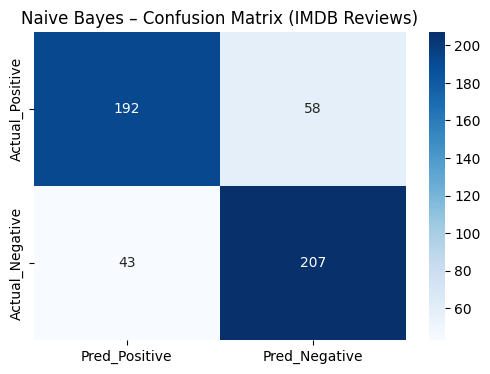


TP=192, FN=58, FP=43, TN=207


In [ ]:
# -----------------------------
# 3. Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_test, y_pred, labels=["positive", "negative"])
cm_df = pd.DataFrame(cm,
                     index=["True_Positive", "True_Negative"],
                     columns=["Predicted_Positive", "Predicted_Negative"])

print("\n=== CONFUSION MATRIX ===")
print(cm_df)

# Visualize confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Naive Bayes – Confusion Matrix (IMDB Reviews)")
plt.show()

# Extract values
TP = cm[0,0]
FN = cm[0,1]
FP = cm[1,0]
TN = cm[1,1]

print(f"\nTP={TP}, FN={FN}, FP={FP}, TN={TN}")


In [14]:
# -----------------------------
# 4. Evaluation Metrics
# -----------------------------

accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label="positive")
recall    = recall_score(y_test, y_pred, pos_label="positive")
f1        = f1_score(y_test, y_pred, pos_label="positive")

print("\n=== METRICS ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred))



=== METRICS ===
Accuracy : 0.7980
Precision: 0.8170
Recall   : 0.7680
F1-score : 0.7918

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

    negative       0.78      0.83      0.80       250
    positive       0.82      0.77      0.79       250

    accuracy                           0.80       500
   macro avg       0.80      0.80      0.80       500
weighted avg       0.80      0.80      0.80       500



In [15]:
from sklearn.metrics import confusion_matrix
import pandas as pd

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=["positive", "negative"])

cm_df = pd.DataFrame(
    cm,
    index=["True Positive", "True Negative"],   # actual labels
    columns=["Predicted Positive", "Predicted Negative"]  # predicted labels
)

print("=== Confusion Matrix ===")
print(cm_df)


=== Confusion Matrix ===
               Predicted Positive  Predicted Negative
True Positive                 192                  58
True Negative                  43                 207


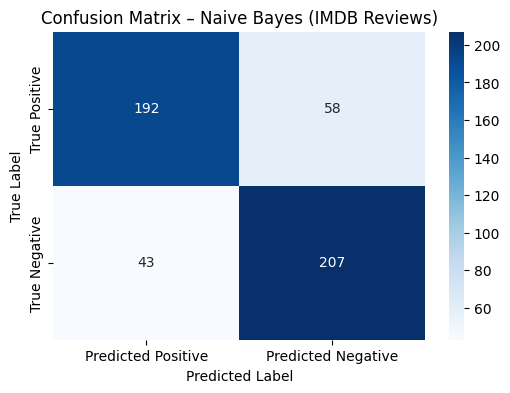

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix – Naive Bayes (IMDB Reviews)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [18]:
correct = TP + TN
total = len(y_test)
print("Correctly classified:", correct, "/", total)


Correctly classified: 399 / 500


In [19]:
# -----------------------------
# 5. Interpretation of Naive Bayes
# -----------------------------

print("\n=== INTERPRETATION OF RESULTS ===")

if FN > FP:
    print("- The model is making more **False Negatives** (positive reviews predicted as negative).")
    print("  → This means the classifier struggles to detect subtle positive sentiment.")
    
if FP > FN:
    print("- The model is making more **False Positives** (negative reviews predicted as positive).")
    print("  → The model is confused by emotionally strong negative words that appear in positive contexts.")

print("- High precision means predictions marked as 'positive' are usually correct.")
print("- High recall means the model can successfully find most positive reviews.")
print("- A gap between precision and recall indicates bias toward one class.")

print("\nGeneral Observations:")
print("* Naive Bayes works well with TF-IDF because it assumes word independence.")
print("* However, it may misclassify reviews with mixed sentiment (e.g., 'The movie was good but slow').")
print("* It also struggles with sarcasm, irony, and highly figurative language.")



=== INTERPRETATION OF RESULTS ===
- The model is making more **False Negatives** (positive reviews predicted as negative).
  → This means the classifier struggles to detect subtle positive sentiment.
- High precision means predictions marked as 'positive' are usually correct.
- High recall means the model can successfully find most positive reviews.
- A gap between precision and recall indicates bias toward one class.

General Observations:
* Naive Bayes works well with TF-IDF because it assumes word independence.
* However, it may misclassify reviews with mixed sentiment (e.g., 'The movie was good but slow').
* It also struggles with sarcasm, irony, and highly figurative language.


# **Step 6: Dimensionality Reduction with PCA**
- Apply Principal Component Analysis (PCA) to the TF-IDF features
- First standardize the data (required for PCA)
- Reduce to the same number of components as SVD for fair comparison
- Compare PCA vs SVD variance curves

--- STEP 6: PCA (Standardize + Reduce) ---


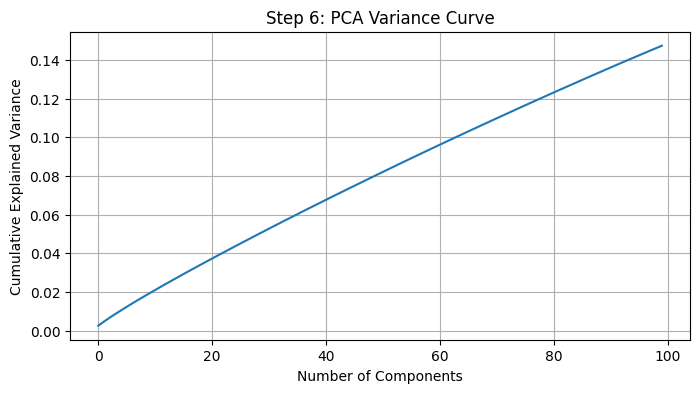

Total Variance Explained by 100 components: 14.74%


In [20]:
# --- PRE-PROCESSING: FIX LABELS & DATA ---
# We force labels to strings to avoid "ValueError"
y_train_str = [str(l).replace('1','positive').replace('0','negative') for l in y_train]
y_test_str  = [str(l).replace('1','positive').replace('0','negative') for l in y_test]

# We convert to dense arrays immediately because PCA requires it
X_train_dense = X_train_tfidf.toarray()
X_test_dense  = X_test_tfidf.toarray()


# ------------------------------------------------------
# STEP 6: Dimensionality Reduction with PCA
# ------------------------------------------------------
print("--- STEP 6: PCA (Standardize + Reduce) ---")

# 1. Standardize the data (Required for PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_dense)
X_test_scaled  = scaler.transform(X_test_dense)

# 2. Apply PCA (Reduce to 100 components to match SVD)
pca = PCA(n_components=100, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

# 3. Visualize Variance Curve (Required for comparison with SVD)
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Step 6: PCA Variance Curve')
plt.grid(True)
plt.show()

print(f"Total Variance Explained by 100 components: {np.sum(pca.explained_variance_ratio_)*100:.2f}%")

**Step 7: Model Training - Logistic Regression with PCA**
*IMPLEMENTING: *
- Train a Logistic Regression classifier on PCA-reduced features
- Make predictions on the test set
- Create and visualize a confusion matrix for the PCA model
- Compare performance with both previous models
- Analyze: Which dimensionality reduction technique works better for text data?


--- STEP 7: Logistic Regression on PCA Features ---


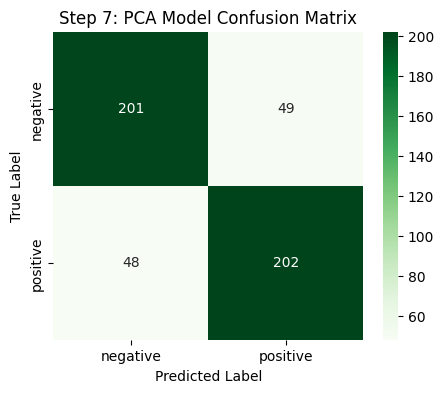

In [21]:
print("\n--- STEP 7: Logistic Regression on PCA Features ---")

# 1. Train Classifier
model_pca = LogisticRegression(solver='liblinear', random_state=42)
model_pca.fit(X_train_pca, y_train_str)

# 2. Make Predictions
y_pred_pca = model_pca.predict(X_test_pca)

# 3. Create Confusion Matrix
labels = ['negative', 'positive']
cm_pca = confusion_matrix(y_test_str, y_pred_pca, labels=labels)

# 4. Visualize Confusion Matrix (Heatmap)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_pca, annot=True, fmt='d', cmap='Greens', 
            xticklabels=labels, yticklabels=labels)
plt.title('Step 7: PCA Model Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

**Step 8: Visual Comparison**
- Visualize all three confusion matrices side-by-side

In [22]:
print("\n--- STEP 8: Performance Comparison ---")

# Retrain Baseline (Naive Bayes) to ensure features match current memory
model_nb = MultinomialNB()
model_nb.fit(X_train_tfidf, y_train_str)
y_pred_nb = model_nb.predict(X_test_tfidf)

# Calculate Accuracies
acc_nb = accuracy_score(y_test_str, y_pred_nb)
acc_pca = accuracy_score(y_test_str, y_pred_pca)

print(f"Model 1 Naive Bayes with TF-IDF  Accuracy: {acc_nb:.4f}")
print(f"Model 2 Logistic Regression with SVD Accuracy: *SVD WILL BE ADDED HERE*")
print(f"Model 3 Logistic Regression with PCA Accuracy: {acc_pca:.4f}")


## Will add SVD results later
if acc_pca >= acc_nb:
    print("\nAnalysis: PCA performed equal to or better than the baseline.")
else:
    print("\nAnalysis: PCA performed worse than the baseline. This is expected as PCA loses some information (5000 -> 100 features).")


--- STEP 8: Performance Comparison ---
Model 1 Naive Bayes with TF-IDF  Accuracy: 0.7980
Model 2 Logistic Regression with SVD Accuracy: *SVD WILL BE ADDED HERE*
Model 3 Logistic Regression with PCA Accuracy: 0.8060

Analysis: PCA performed equal to or better than the baseline.
